In [1]:
# To ignore possible warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importing all necessary libraries used in the code
import numpy as np  
import pandas as pd
from PIL import Image  

import torch
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import torch.optim as optim

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# About the dataset
<p style = "text-align: justify;">
Generally, the dataset contains 200 various bird species with 50-60 images per class and total number of images is 11.8k. The shape of each image differs from each other significantly, for example, 3x300x500, 3x337x400, 3x400x500 and so on. 
</p>

# About the model. 
<p style = "text-align: justify;">
In this notebook, I have built the model from scratch.
</p>

# EfficientNet-B0 from scratch

In [4]:
class SqueezeExcitation(nn.Module):
    def __init__(self, in_channels, reduction_ratio = 4): 
        super(SqueezeExcitation, self).__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, in_channels // reduction_ratio, kernel_size=1),
            nn.SiLU(),
            nn.Conv2d(in_channels // reduction_ratio, in_channels, kernel_size=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return x * self.se(x)

In [5]:
class MBConvBlock(nn.Module):
    def __init__(self, in_channels, 
                 out_channels, 
                 expand_ratio, 
                 kernel_size, 
                 stride, 
                 reduction_ratio=4, 
                 dropout_rate=0.2):
        super(MBConvBlock, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.expansion_factor = expand_ratio
        self.kernel_size = kernel_size
        self.stride = stride
        self.reduction_ratio = reduction_ratio
        self.dropout_rate = dropout_rate

        expanded_channels = expand_ratio * in_channels
        if self.expansion_factor != 1:
            self.expansion_sequence = nn.Sequential(
                nn.Conv2d(in_channels, expanded_channels, kernel_size=1, stride=1, padding=0, bias=False),
                nn.BatchNorm2d(expanded_channels),
                nn.SiLU(),
            )
        
        self.dw_conv = nn.Conv2d(expanded_channels, expanded_channels, 
                                 kernel_size=kernel_size, 
                                 stride=stride, padding=(kernel_size - 1) // 2, 
                                 groups=expanded_channels, bias=False)
        self.dw_bn = nn.BatchNorm2d(expanded_channels)
        self.dw_swish = nn.SiLU()
        if self.reduction_ratio is not None:
            self.SE = SqueezeExcitation(expanded_channels, reduction_ratio)
        self.conv2 = nn.Conv2d(expanded_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        out = x
        if self.expansion_factor != 1:
            out = self.expansion_sequence(x)

        out = self.dw_conv(out)
        out = self.dw_bn(out)
        out = self.dw_swish(out)
        if self.reduction_ratio is not None:
            out = self.SE(out)
        out = self.conv2(out)
        out = self.bn2(out)

        # Skip connection
        if self.stride == 1 and out.shape[1] == x.shape[1]:
            out += x

        
        drop = nn.Dropout(self.dropout_rate)
        out = drop(out)
        return out

In [9]:
class EfficientNet(nn.Module):
    def __init__(self, num_classes, Net_type = "B0"):
        super(EfficientNet, self).__init__()

        # conv stem
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.swish1 = nn.SiLU()
        
        if Net_type == "B0" or Net_type  == "b0":
            self.blocks = nn.Sequential(
                    MBConvBlock(32, 16, kernel_size=3, stride=1, expand_ratio=1),
                    MBConvBlock(16, 24, kernel_size=3, stride=2, expand_ratio=6),
                    MBConvBlock(24, 24, kernel_size=3, stride=1, expand_ratio=6),
                    MBConvBlock(24, 40, kernel_size=5, stride=2, expand_ratio=6),
                    MBConvBlock(40, 40, kernel_size=5, stride=1, expand_ratio=6),
                    MBConvBlock(40, 80, kernel_size=3, stride=2, expand_ratio=6),
                    MBConvBlock(80, 80, kernel_size=3, stride=1, expand_ratio=6),
                    MBConvBlock(80, 80, kernel_size=3, stride=1, expand_ratio=6),
                    MBConvBlock(80, 112, kernel_size=5, stride=1, expand_ratio=6),
                    MBConvBlock(112, 112, kernel_size=5, stride=1, expand_ratio=6),
                    MBConvBlock(112, 112, kernel_size=5, stride=1, expand_ratio=6),
                    MBConvBlock(112, 192, kernel_size=5, stride=2, expand_ratio=6),
                    MBConvBlock(192, 192, kernel_size=5, stride=1, expand_ratio=6),
                    MBConvBlock(192, 192, kernel_size=5, stride=1, expand_ratio=6),
                    MBConvBlock(192, 192, kernel_size=5, stride=1, expand_ratio=6),
                    MBConvBlock(192, 320, kernel_size=3, stride=1, expand_ratio=6),
                )
        
        elif Net_type == "B1" or Net_type  == "b1":
            self.blocks = nn.Sequential(
                    MBConvBlock(32, 16, kernel_size=3, stride=1, expand_ratio=1),
                    MBConvBlock(16, 16, kernel_size=3, stride=1, expand_ratio=1),
                    MBConvBlock(16, 24, kernel_size=3, stride=2, expand_ratio=6),
                    MBConvBlock(24, 24, kernel_size=3, stride=1, expand_ratio=6),
                    MBConvBlock(24, 24, kernel_size=3, stride=1, expand_ratio=6),
                    MBConvBlock(24, 40, kernel_size=5, stride=2, expand_ratio=6),
                    MBConvBlock(40, 40, kernel_size=5, stride=1, expand_ratio=6),
                    MBConvBlock(40, 40, kernel_size=5, stride=1, expand_ratio=6),
                    MBConvBlock(40, 80, kernel_size=3, stride=2, expand_ratio=6),
                    MBConvBlock(80, 80, kernel_size=3, stride=1, expand_ratio=6),
                    MBConvBlock(80, 80, kernel_size=3, stride=1, expand_ratio=6),
                    MBConvBlock(80, 80, kernel_size=3, stride=1, expand_ratio=6),
                    MBConvBlock(80, 112, kernel_size=5, stride=1, expand_ratio=6),
                    MBConvBlock(112, 112, kernel_size=5, stride=1, expand_ratio=6),
                    MBConvBlock(112, 112, kernel_size=5, stride=1, expand_ratio=6),
                    MBConvBlock(112, 112, kernel_size=5, stride=1, expand_ratio=6),
                    MBConvBlock(112, 192, kernel_size=5, stride=2, expand_ratio=6),
                    MBConvBlock(192, 192, kernel_size=5, stride=1, expand_ratio=6),
                    MBConvBlock(192, 192, kernel_size=5, stride=1, expand_ratio=6),
                    MBConvBlock(192, 192, kernel_size=5, stride=1, expand_ratio=6),
                    MBConvBlock(192, 192, kernel_size=5, stride=1, expand_ratio=6),
                    MBConvBlock(192, 320, kernel_size=3, stride=1, expand_ratio=6),
                    MBConvBlock(320, 320, kernel_size=3, stride=1, expand_ratio=6),
                )
            
        self.rest = nn.Sequential(
            nn.Conv2d(320, 1280, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(1280),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Dropout(0.2),
        ) 

        self.last_layers = nn.Sequential(
            nn.Linear(1280, num_classes),
            nn.SiLU(),
        )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.swish1(out)
        out = self.blocks(out)
        out = self.rest(out)
        
        out = out.view(out.size(0), -1)
        out = self.last_layers(out)

        return out

In [ ]:
m = EfficientNet(200, Net_type = "B0")
m.train()  # Look at the architecture

EfficientNetB0(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (swish1): SiLU()
  (blocks): Sequential(
    (0): MBConvBlock(
      (dw_conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (dw_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dw_swish): SiLU()
      (SE): SqueezeExcitation(
        (se): Sequential(
          (0): AdaptiveAvgPool2d(output_size=1)
          (1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (2): SiLU()
          (3): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (4): Sigmoid()
        )
      )
      (conv2): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): MBConvBlock(
      (expansion_seq

In [10]:
m = EfficientNet(200, Net_type = "B1")
m.train()  # Look at the architecture

EfficientNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (swish1): SiLU()
  (blocks): Sequential(
    (0): MBConvBlock(
      (dw_conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (dw_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dw_swish): SiLU()
      (SE): SqueezeExcitation(
        (se): Sequential(
          (0): AdaptiveAvgPool2d(output_size=1)
          (1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (2): SiLU()
          (3): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (4): Sigmoid()
        )
      )
      (conv2): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): MBConvBlock(
      (dw_conv): Conv2

In [11]:
def is_there_GPU():
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print("There is a GPU available.")
    else:
        device = torch.device("cpu")
        print("There is no GPU available, using CPU instead.")
    return device

device = is_there_GPU()

There is a GPU available.


# Model 1 - Using original images (11788 images with 200 classes) with EfficientNet-B0 typed from scratch

In [ ]:
data_dir = "./drive/MyDrive/images"

transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
])

dataset = ImageFolder(root=data_dir, transform=transform)

#### Stratified data splitting (training, validation and test)

In [16]:
from sklearn.model_selection import StratifiedShuffleSplit

def train_test_validation2(dataset, targets):
    stratified_split = StratifiedShuffleSplit(n_splits=1, train_size=0.8, test_size=0.2)

    for train_indices, indices in stratified_split.split(dataset, targets):
        train_dataset = torch.utils.data.Subset(dataset, train_indices)
        
        dct = {}
        val_indices = []
        test_indices = []

        for i in indices:
            x = targets[i]

            if x not in dct.keys():
                dct[x] = 1
                test_indices.append(i)
            elif dct[x] % 2 == 0:
                test_indices.append(i)
                dct[x] += 1
            else:
                val_indices.append(i)  
                dct[x] += 1 

        test_dataset = torch.utils.data.Subset(dataset, test_indices)
        val_dataset = torch.utils.data.Subset(dataset, val_indices)

    return train_dataset, test_dataset, val_dataset

In [ ]:
train_dataset, test_dataset, val_dataset = train_test_validation2(dataset, dataset.targets)

In [ ]:
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"Entire dataset size: {len(dataset)}")

Train dataset size: 9430
Validation dataset size: 1173
Test dataset size: 1185
Entire dataset size: 11788


In [20]:
# Set up data loaders for each set
def loaders(batch_size, train_dataset, val_dataset, test_dataset):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    return train_loader, val_loader, test_loader

In [ ]:
train_loader, val_loader, test_loader = loaders(32, train_dataset, val_dataset, test_dataset)

In [ ]:
# General function to find the number of samples in dataset
def sample_count(indices, all_targets):
  dct = {}
  for i in indices:
    x = all_targets[i]
    if x in dct.keys():
      dct[x] += 1
    else:
      dct[x] = 1

  for i in sorted(dct.keys()):
    print(f"{i} -> {dct[i]}")

In [ ]:
# Test samples
sample_count(test_dataset.indices, test_dataset.dataset.targets)

0 -> 6
1 -> 6
2 -> 6
3 -> 6
4 -> 5
5 -> 4
6 -> 5
7 -> 5
8 -> 6
9 -> 6
10 -> 6
11 -> 6
12 -> 6
13 -> 6
14 -> 6
15 -> 6
16 -> 6
17 -> 5
18 -> 6
19 -> 6
20 -> 6
21 -> 6
22 -> 6
23 -> 5
24 -> 6
25 -> 6
26 -> 6
27 -> 6
28 -> 6
29 -> 6
30 -> 6
31 -> 5
32 -> 6
33 -> 6
34 -> 6
35 -> 6
36 -> 6
37 -> 6
38 -> 6
39 -> 6
40 -> 6
41 -> 6
42 -> 6
43 -> 6
44 -> 6
45 -> 6
46 -> 6
47 -> 6
48 -> 6
49 -> 6
50 -> 6
51 -> 6
52 -> 6
53 -> 6
54 -> 6
55 -> 6
56 -> 6
57 -> 6
58 -> 6
59 -> 6
60 -> 6
61 -> 6
62 -> 6
63 -> 6
64 -> 5
65 -> 6
66 -> 6
67 -> 6
68 -> 6
69 -> 6
70 -> 6
71 -> 6
72 -> 6
73 -> 6
74 -> 6
75 -> 6
76 -> 6
77 -> 6
78 -> 6
79 -> 6
80 -> 6
81 -> 6
82 -> 6
83 -> 5
84 -> 6
85 -> 6
86 -> 6
87 -> 6
88 -> 6
89 -> 6
90 -> 6
91 -> 6
92 -> 6
93 -> 6
94 -> 6
95 -> 6
96 -> 6
97 -> 6
98 -> 6
99 -> 6
100 -> 5
101 -> 6
102 -> 6
103 -> 6
104 -> 5
105 -> 6
106 -> 6
107 -> 6
108 -> 6
109 -> 6
110 -> 6
111 -> 6
112 -> 5
113 -> 6
114 -> 6
115 -> 6
116 -> 6
117 -> 6
118 -> 6
119 -> 6
120 -> 6
121 -> 6
122 -> 6
123

#### Model, optimizer and loss

In [ ]:
model = EfficientNet(200)
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
criterion = nn.CrossEntropyLoss()

#### Training

In [13]:
def model_training(model, optimizer, criterion, num_epochs, start_epoch_num = 0):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0
        
        for batch, labels in train_loader:
            batch, labels = batch.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(batch)
            _, preds = torch.max(outputs, 1)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = running_corrects.double() / len(train_dataset)
        print(f'Epoch {start_epoch_num+epoch+1}/{start_epoch_num+num_epochs} | Train loss: {epoch_loss:.4f} | Train accuracy: {epoch_acc:.4f}')
        
        # Validation
        model.eval()
        running_val_loss = 0.0
        running_val_corrects = 0
        
        for batch, labels in val_loader:
            with torch.no_grad():
                batch, labels = batch.to(device), labels.to(device)

                outputs = model(batch)
                val_loss = criterion(outputs, labels)
                running_val_loss += val_loss.item()
                _, val_preds = torch.max(outputs, 1)
                running_val_corrects += torch.sum(val_preds == labels.data)
        
        val_loss = running_val_loss / len(val_dataset)
        val_acc = running_val_corrects.double() / len(val_dataset)
        print(f'Epoch {start_epoch_num+epoch+1}/{start_epoch_num+num_epochs} | Validation loss: {val_loss:.4f} | Validation accuracy: {val_acc:.4f}')
    
    return model

In [ ]:
num_epochs = 30
model_1 = model_training(model, optimizer, criterion, num_epochs) 

Epoch 1/30 | Train loss: 0.1663 | Train accuracy: 0.0081
Epoch 1/30 | Validation loss: 0.1651 | Validation accuracy: 0.0051
Epoch 2/30 | Train loss: 0.1613 | Train accuracy: 0.0095
Epoch 2/30 | Validation loss: 0.1594 | Validation accuracy: 0.0162
Epoch 3/30 | Train loss: 0.1564 | Train accuracy: 0.0195
Epoch 3/30 | Validation loss: 0.1546 | Validation accuracy: 0.0264
Epoch 4/30 | Train loss: 0.1493 | Train accuracy: 0.0281
Epoch 4/30 | Validation loss: 0.1485 | Validation accuracy: 0.0367
Epoch 5/30 | Train loss: 0.1436 | Train accuracy: 0.0371
Epoch 5/30 | Validation loss: 0.1415 | Validation accuracy: 0.0503
Epoch 6/30 | Train loss: 0.1403 | Train accuracy: 0.0433
Epoch 6/30 | Validation loss: 0.1404 | Validation accuracy: 0.0537
Epoch 7/30 | Train loss: 0.1354 | Train accuracy: 0.0600
Epoch 7/30 | Validation loss: 0.1341 | Validation accuracy: 0.0699
Epoch 8/30 | Train loss: 0.1313 | Train accuracy: 0.0733
Epoch 8/30 | Validation loss: 0.1339 | Validation accuracy: 0.0725
Epoch 9/

In [ ]:
num_epochs = 10
model_1 = model_training(model_1, optimizer, criterion, num_epochs, start_epoch_num = 30) 

Epoch 31/40 | Train loss: 0.0627 | Train accuracy: 0.4444
Epoch 31/40 | Validation loss: 0.0892 | Validation accuracy: 0.3223
Epoch 32/40 | Train loss: 0.0604 | Train accuracy: 0.4687
Epoch 32/40 | Validation loss: 0.0894 | Validation accuracy: 0.3521
Epoch 33/40 | Train loss: 0.0586 | Train accuracy: 0.4776
Epoch 33/40 | Validation loss: 0.0901 | Validation accuracy: 0.3180
Epoch 34/40 | Train loss: 0.0558 | Train accuracy: 0.4993
Epoch 34/40 | Validation loss: 0.0833 | Validation accuracy: 0.3606
Epoch 35/40 | Train loss: 0.0551 | Train accuracy: 0.5002
Epoch 35/40 | Validation loss: 0.0956 | Validation accuracy: 0.3069
Epoch 36/40 | Train loss: 0.0528 | Train accuracy: 0.5163
Epoch 36/40 | Validation loss: 0.0960 | Validation accuracy: 0.3393
Epoch 37/40 | Train loss: 0.0500 | Train accuracy: 0.5359
Epoch 37/40 | Validation loss: 0.0981 | Validation accuracy: 0.3325
Epoch 38/40 | Train loss: 0.0483 | Train accuracy: 0.5514
Epoch 38/40 | Validation loss: 0.0926 | Validation accuracy:

In [ ]:
num_epochs = 10
model_1 = model_training(model_1, optimizer, criterion, num_epochs, start_epoch_num = 40) 

Epoch 41/50 | Train loss: 0.0446 | Train accuracy: 0.5794
Epoch 41/50 | Validation loss: 0.0921 | Validation accuracy: 0.3760
Epoch 42/50 | Train loss: 0.0412 | Train accuracy: 0.6023
Epoch 42/50 | Validation loss: 0.1019 | Validation accuracy: 0.3564
Epoch 43/50 | Train loss: 0.0406 | Train accuracy: 0.6157
Epoch 43/50 | Validation loss: 0.1003 | Validation accuracy: 0.3495
Epoch 44/50 | Train loss: 0.0391 | Train accuracy: 0.6220
Epoch 44/50 | Validation loss: 0.0990 | Validation accuracy: 0.3529
Epoch 45/50 | Train loss: 0.0380 | Train accuracy: 0.6352
Epoch 45/50 | Validation loss: 0.0970 | Validation accuracy: 0.3802
Epoch 46/50 | Train loss: 0.0365 | Train accuracy: 0.6458
Epoch 46/50 | Validation loss: 0.1064 | Validation accuracy: 0.3316
Epoch 47/50 | Train loss: 0.0346 | Train accuracy: 0.6656
Epoch 47/50 | Validation loss: 0.1024 | Validation accuracy: 0.3819
Epoch 48/50 | Train loss: 0.0336 | Train accuracy: 0.6740
Epoch 48/50 | Validation loss: 0.1028 | Validation accuracy:

In [14]:
def model_testing(model):
    model.eval()
    test_running_loss = 0.0
    test_running_corrects = 0

    with torch.no_grad():
        for batch, labels in test_loader:
            batch, labels = batch.to(device), labels.to(device)
            outputs = model(batch)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            test_running_loss += loss.item()
            test_running_corrects += torch.sum(preds == labels.data)

    test_epoch_loss = test_running_loss / len(test_dataset)
    test_epoch_acc = test_running_corrects.double() / len(test_dataset)
    print(f'Test loss: {test_epoch_loss:.4f} | Test accuracy: {test_epoch_acc:.4f}')

In [ ]:
model_testing(model)

Test loss: 0.1044 | Test accuracy: 0.3536


# Model 2. First dataset with the cropped version and white unsegmented parts. 

In [ ]:
data_dir = "./drive/MyDrive/new_dataset"

transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
])

dataset = ImageFolder(root=data_dir, transform=transform)

In [ ]:
train_dataset, test_dataset, val_dataset = train_test_validation2(dataset, dataset.targets)

In [ ]:
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"Entire dataset size: {len(dataset)}")

Train dataset size: 9423
Validation dataset size: 1171
Test dataset size: 1185
Entire dataset size: 11779


In [ ]:
train_loader, val_loader, test_loader = loaders(32, train_dataset, val_dataset, test_dataset)

In [ ]:
model = EfficientNet(200)
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [ ]:
num_epochs = 30
model_2 = model_training(model, optimizer, criterion, num_epochs) 

Epoch 1/30 | Train loss: 0.1606 | Train accuracy: 0.0170
Epoch 1/30 | Validation loss: 0.1628 | Validation accuracy: 0.0248
Epoch 2/30 | Train loss: 0.1402 | Train accuracy: 0.0540
Epoch 2/30 | Validation loss: 0.1393 | Validation accuracy: 0.0529
Epoch 3/30 | Train loss: 0.1254 | Train accuracy: 0.0960
Epoch 3/30 | Validation loss: 0.1288 | Validation accuracy: 0.1067
Epoch 4/30 | Train loss: 0.1131 | Train accuracy: 0.1523
Epoch 4/30 | Validation loss: 0.1187 | Validation accuracy: 0.1392
Epoch 5/30 | Train loss: 0.1038 | Train accuracy: 0.1958
Epoch 5/30 | Validation loss: 0.1087 | Validation accuracy: 0.1904
Epoch 6/30 | Train loss: 0.0957 | Train accuracy: 0.2454
Epoch 6/30 | Validation loss: 0.1072 | Validation accuracy: 0.2135
Epoch 7/30 | Train loss: 0.0887 | Train accuracy: 0.2888
Epoch 7/30 | Validation loss: 0.0941 | Validation accuracy: 0.2733
Epoch 8/30 | Train loss: 0.0819 | Train accuracy: 0.3275
Epoch 8/30 | Validation loss: 0.0896 | Validation accuracy: 0.3049
Epoch 9/

In [ ]:
num_epochs = 10
model_2 = model_training(model_2, optimizer, criterion, num_epochs, start_epoch_num = 30) 

Epoch 31/40 | Train loss: 0.0182 | Train accuracy: 0.8121
Epoch 31/40 | Validation loss: 0.0803 | Validation accuracy: 0.5406
Epoch 32/40 | Train loss: 0.0173 | Train accuracy: 0.8247
Epoch 32/40 | Validation loss: 0.0792 | Validation accuracy: 0.5286
Epoch 33/40 | Train loss: 0.0158 | Train accuracy: 0.8352
Epoch 33/40 | Validation loss: 0.0935 | Validation accuracy: 0.4987
Epoch 34/40 | Train loss: 0.0154 | Train accuracy: 0.8370
Epoch 34/40 | Validation loss: 0.0887 | Validation accuracy: 0.5056
Epoch 35/40 | Train loss: 0.0143 | Train accuracy: 0.8534
Epoch 35/40 | Validation loss: 0.0811 | Validation accuracy: 0.5491
Epoch 36/40 | Train loss: 0.0125 | Train accuracy: 0.8751
Epoch 36/40 | Validation loss: 0.1006 | Validation accuracy: 0.4765
Epoch 37/40 | Train loss: 0.0136 | Train accuracy: 0.8599
Epoch 37/40 | Validation loss: 0.0967 | Validation accuracy: 0.5038
Epoch 38/40 | Train loss: 0.0129 | Train accuracy: 0.8648
Epoch 38/40 | Validation loss: 0.0978 | Validation accuracy:

In [ ]:
model_testing(model_2)

Test loss: 0.0980 | Test accuracy: 0.5097


# Model 3. New dataset containing 3308 images with 20 classes.

In [ ]:
data_dir = "./drive/MyDrive/d2_entire_dataset"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

dataset = ImageFolder(root=data_dir, transform=transform)

In [ ]:
train_dataset, test_dataset, val_dataset = train_test_validation2(dataset, dataset.targets)

In [ ]:
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"Entire dataset size: {len(dataset)}")

Train dataset size: 2646
Validation dataset size: 327
Test dataset size: 335
Entire dataset size: 3308


In [ ]:
train_loader, val_loader, test_loader = loaders(16, train_dataset, val_dataset, test_dataset)

In [ ]:
# Test samples
sample_count(test_dataset.indices, test_dataset.dataset.targets)

0 -> 17
1 -> 19
2 -> 19
3 -> 14
4 -> 16
5 -> 14
6 -> 16
7 -> 19
8 -> 19
9 -> 14
10 -> 17
11 -> 17
12 -> 17
13 -> 16
14 -> 19
15 -> 18
16 -> 17
17 -> 17
18 -> 14
19 -> 16


In [ ]:
model = EfficientNet(20)
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [ ]:
num_epochs = 10
model = model_training(model, optimizer, criterion, num_epochs) 

Epoch 1/10 | Train loss: 0.1814 | Train accuracy: 0.1066
Epoch 1/10 | Validation loss: 0.1771 | Validation accuracy: 0.1651
Epoch 2/10 | Train loss: 0.1623 | Train accuracy: 0.2086
Epoch 2/10 | Validation loss: 0.2353 | Validation accuracy: 0.0398
Epoch 3/10 | Train loss: 0.1435 | Train accuracy: 0.2831
Epoch 3/10 | Validation loss: 0.1196 | Validation accuracy: 0.4128
Epoch 4/10 | Train loss: 0.1213 | Train accuracy: 0.4074
Epoch 4/10 | Validation loss: 0.1157 | Validation accuracy: 0.4587
Epoch 5/10 | Train loss: 0.1043 | Train accuracy: 0.4796
Epoch 5/10 | Validation loss: 0.1050 | Validation accuracy: 0.4954
Epoch 6/10 | Train loss: 0.0932 | Train accuracy: 0.5283
Epoch 6/10 | Validation loss: 0.0822 | Validation accuracy: 0.5933
Epoch 7/10 | Train loss: 0.0830 | Train accuracy: 0.5786
Epoch 7/10 | Validation loss: 0.0863 | Validation accuracy: 0.5688
Epoch 8/10 | Train loss: 0.0753 | Train accuracy: 0.6221
Epoch 8/10 | Validation loss: 0.0740 | Validation accuracy: 0.6116
Epoch 9/

In [ ]:
num_epochs = 5
model = model_training(model, optimizer, criterion, num_epochs, start_epoch_num = 10) 

Epoch 11/15 | Train loss: 0.0559 | Train accuracy: 0.7192
Epoch 11/15 | Validation loss: 0.0669 | Validation accuracy: 0.6758
Epoch 12/15 | Train loss: 0.0506 | Train accuracy: 0.7438
Epoch 12/15 | Validation loss: 0.0673 | Validation accuracy: 0.7003
Epoch 13/15 | Train loss: 0.0448 | Train accuracy: 0.7604
Epoch 13/15 | Validation loss: 0.0543 | Validation accuracy: 0.7554
Epoch 14/15 | Train loss: 0.0453 | Train accuracy: 0.7634
Epoch 14/15 | Validation loss: 0.0582 | Validation accuracy: 0.7339
Epoch 15/15 | Train loss: 0.0424 | Train accuracy: 0.7774
Epoch 15/15 | Validation loss: 0.0540 | Validation accuracy: 0.7554


In [ ]:
num_epochs = 5
model = model_training(model, optimizer, criterion, num_epochs, start_epoch_num = 15) 

Epoch 16/20 | Train loss: 0.0372 | Train accuracy: 0.8069
Epoch 16/20 | Validation loss: 0.0578 | Validation accuracy: 0.7462
Epoch 17/20 | Train loss: 0.0351 | Train accuracy: 0.8224
Epoch 17/20 | Validation loss: 0.0453 | Validation accuracy: 0.8012
Epoch 18/20 | Train loss: 0.0304 | Train accuracy: 0.8409
Epoch 18/20 | Validation loss: 0.0467 | Validation accuracy: 0.7737
Epoch 19/20 | Train loss: 0.0307 | Train accuracy: 0.8466
Epoch 19/20 | Validation loss: 0.0493 | Validation accuracy: 0.7615
Epoch 20/20 | Train loss: 0.0265 | Train accuracy: 0.8568
Epoch 20/20 | Validation loss: 0.0432 | Validation accuracy: 0.7982


In [ ]:
num_epochs = 5
model = model_training(model, optimizer, criterion, num_epochs, start_epoch_num = 20) 

Epoch 21/25 | Train loss: 0.0272 | Train accuracy: 0.8556
Epoch 21/25 | Validation loss: 0.0410 | Validation accuracy: 0.7982
Epoch 22/25 | Train loss: 0.0222 | Train accuracy: 0.8893
Epoch 22/25 | Validation loss: 0.0400 | Validation accuracy: 0.8043
Epoch 23/25 | Train loss: 0.0217 | Train accuracy: 0.8859
Epoch 23/25 | Validation loss: 0.0450 | Validation accuracy: 0.8104
Epoch 24/25 | Train loss: 0.0199 | Train accuracy: 0.8912
Epoch 24/25 | Validation loss: 0.0483 | Validation accuracy: 0.7982
Epoch 25/25 | Train loss: 0.0191 | Train accuracy: 0.8983
Epoch 25/25 | Validation loss: 0.0440 | Validation accuracy: 0.8043


In [ ]:
num_epochs = 5
model = model_training(model, optimizer, criterion, num_epochs, start_epoch_num = 25) 

Epoch 26/30 | Train loss: 0.0182 | Train accuracy: 0.9070
Epoch 26/30 | Validation loss: 0.0449 | Validation accuracy: 0.8135
Epoch 27/30 | Train loss: 0.0143 | Train accuracy: 0.9191
Epoch 27/30 | Validation loss: 0.0426 | Validation accuracy: 0.8043
Epoch 28/30 | Train loss: 0.0171 | Train accuracy: 0.9097
Epoch 28/30 | Validation loss: 0.0509 | Validation accuracy: 0.7737
Epoch 29/30 | Train loss: 0.0134 | Train accuracy: 0.9293
Epoch 29/30 | Validation loss: 0.0469 | Validation accuracy: 0.7676
Epoch 30/30 | Train loss: 0.0123 | Train accuracy: 0.9331
Epoch 30/30 | Validation loss: 0.0448 | Validation accuracy: 0.8104


In [15]:
def model_testing2(model):
    model.eval()
    test_running_loss = 0.0
    test_running_corrects = 0
    wrong_predictions = []  # initialize a list to store wrong predictions

    with torch.no_grad():
        for batch, labels in test_loader:
            batch, labels = batch.to(device), labels.to(device)
            outputs = model(batch)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            test_running_loss += loss.item()
            test_running_corrects += torch.sum(preds == labels.data)

            # Collect wrong predictions
            for i in range(len(labels)):
                if preds[i] != labels[i]:
                    wrong_predictions.append({
                        'actual_class': labels[i],
                        'predicted_class': preds[i],
                        'feature': batch[i]
                    })

    test_epoch_loss = test_running_loss / len(test_dataset)
    test_epoch_acc = test_running_corrects.double() / len(test_dataset)
    print(f'Test loss: {test_epoch_loss:.4f} | Test accuracy: {test_epoch_acc:.4f}')

    return wrong_predictions

In [ ]:
def represent_wrong_predictions(wrong_predictions, count = None):
    for i, wp in enumerate(wrong_predictions):
        print(f'Wrong prediction {i+1}: Actual class -> {wp["actual_class"]}, Predicted class -> {wp["predicted_class"]}')
        
        if i >= count:
            break

def display_image(x):
    tensor = x.cpu().detach()  
    tensor = tensor.permute(1, 2, 0)  
    img_array = np.uint8(255 * tensor.numpy())
    img = Image.fromarray(img_array)
    img.show()

In [ ]:
wp = model_testing2(model)

Test loss: 0.0584 | Test accuracy: 0.7731


In [ ]:
print(f"The number of wrong predictions: {len(wp)}")
print(f"The number of correct predictions: {len(test_dataset) - len(wp)}")

The number of wrong predictions: 76
The number of correct predictions: 259


In [ ]:
# Some of the wrong predictions
represent_wrong_predictions(wp, 5)

import os
lst = os.listdir("./drive/MyDrive/d2_entire_dataset")
lst.sort()

Wrong prediction 1: Actual class -> 3, Predicted class -> 1
Wrong prediction 2: Actual class -> 5, Predicted class -> 11
Wrong prediction 3: Actual class -> 10, Predicted class -> 0
Wrong prediction 4: Actual class -> 7, Predicted class -> 2
Wrong prediction 5: Actual class -> 0, Predicted class -> 10
Wrong prediction 6: Actual class -> 4, Predicted class -> 12


In [ ]:
# Some of the wrong predictions
print(f"Wrong prediction 1: Actual class -> {lst[3]}, Predicted class -> {lst[1]}")
print(f"Wrong prediction 2: Actual class -> {lst[5]}, Predicted class -> {lst[11]}")
print(f"Wrong prediction 3: Actual class -> {lst[10]}, Predicted class -> {lst[0]}")
print(f"Wrong prediction 4: Actual class -> {lst[7]}, Predicted class -> {lst[2]}")
print(f"Wrong prediction 5: Actual class -> {lst[0]}, Predicted class -> {lst[10]}")
print(f"Wrong prediction 6: Actual class -> {lst[4]}, Predicted class -> {lst[12]}")

Wrong prediction 1: Actual class -> AFRICAN CROWNED CRANE, Predicted class -> ABBOTTS BOOBY
Wrong prediction 2: Actual class -> AFRICAN FIREFINCH, Predicted class -> ALEXANDRINE PARAKEET
Wrong prediction 3: Actual class -> ALBERTS TOWHEE, Predicted class -> ABBOTTS BABBLER
Wrong prediction 4: Actual class -> AFRICAN PIED HORNBILL, Predicted class -> ABYSSINIAN GROUND HORNBILL
Wrong prediction 5: Actual class -> ABBOTTS BABBLER, Predicted class -> ALBERTS TOWHEE
Wrong prediction 6: Actual class -> AFRICAN EMERALD CUCKOO, Predicted class -> ALPINE CHOUGH


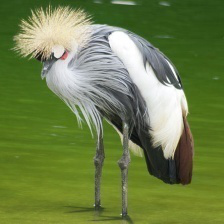

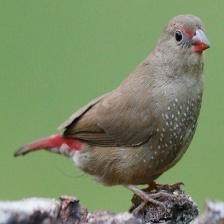

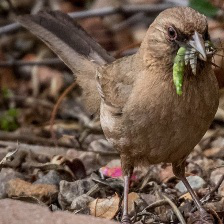

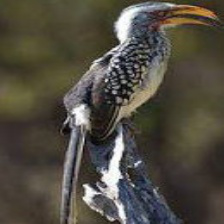

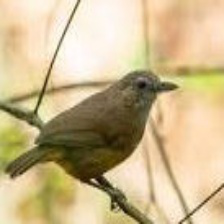

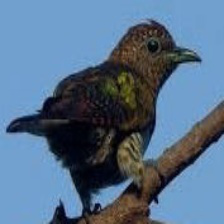

In [ ]:
i = 0
while i <= 5:
    display_image(wp[i]['feature']) 
    i += 1

# Model 4 - New dataset but with Adam optimizer

In [ ]:
model = EfficientNet(20)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [ ]:
num_epochs = 20
model1 = model_training(model, optimizer, criterion, num_epochs) 

Epoch 1/20 | Train loss: 0.1836 | Train accuracy: 0.0930
Epoch 1/20 | Validation loss: 0.1827 | Validation accuracy: 0.1162
Epoch 2/20 | Train loss: 0.1626 | Train accuracy: 0.1784
Epoch 2/20 | Validation loss: 0.1769 | Validation accuracy: 0.2385
Epoch 3/20 | Train loss: 0.1591 | Train accuracy: 0.1950
Epoch 3/20 | Validation loss: 0.1567 | Validation accuracy: 0.1774
Epoch 4/20 | Train loss: 0.1535 | Train accuracy: 0.2158
Epoch 4/20 | Validation loss: 0.1525 | Validation accuracy: 0.2722
Epoch 5/20 | Train loss: 0.1471 | Train accuracy: 0.2536
Epoch 5/20 | Validation loss: 0.1428 | Validation accuracy: 0.2630
Epoch 6/20 | Train loss: 0.1403 | Train accuracy: 0.2717
Epoch 6/20 | Validation loss: 0.1494 | Validation accuracy: 0.2844
Epoch 7/20 | Train loss: 0.1295 | Train accuracy: 0.3379
Epoch 7/20 | Validation loss: 0.1310 | Validation accuracy: 0.3884
Epoch 8/20 | Train loss: 0.1115 | Train accuracy: 0.4184
Epoch 8/20 | Validation loss: 0.1059 | Validation accuracy: 0.4404
Epoch 9/

In [ ]:
num_epochs = 10
model2 = model_training(model1, optimizer, criterion, num_epochs, start_epoch_num = 20) 

Epoch 21/30 | Train loss: 0.0342 | Train accuracy: 0.8118
Epoch 21/30 | Validation loss: 0.0746 | Validation accuracy: 0.6606
Epoch 22/30 | Train loss: 0.0328 | Train accuracy: 0.8250
Epoch 22/30 | Validation loss: 0.0782 | Validation accuracy: 0.6636
Epoch 23/30 | Train loss: 0.0301 | Train accuracy: 0.8398
Epoch 23/30 | Validation loss: 0.0675 | Validation accuracy: 0.7187
Epoch 24/30 | Train loss: 0.0287 | Train accuracy: 0.8450
Epoch 24/30 | Validation loss: 0.0729 | Validation accuracy: 0.7248
Epoch 25/30 | Train loss: 0.0267 | Train accuracy: 0.8560
Epoch 25/30 | Validation loss: 0.0706 | Validation accuracy: 0.7095
Epoch 26/30 | Train loss: 0.0226 | Train accuracy: 0.8741
Epoch 26/30 | Validation loss: 0.0649 | Validation accuracy: 0.7187
Epoch 27/30 | Train loss: 0.0213 | Train accuracy: 0.8840
Epoch 27/30 | Validation loss: 0.0690 | Validation accuracy: 0.7034
Epoch 28/30 | Train loss: 0.0204 | Train accuracy: 0.8919
Epoch 28/30 | Validation loss: 0.0646 | Validation accuracy:

In [ ]:
num_epochs = 10
model3 = model_training(model2, optimizer, criterion, num_epochs, start_epoch_num = 30) 

Epoch 31/40 | Train loss: 0.0182 | Train accuracy: 0.9104
Epoch 31/40 | Validation loss: 0.0751 | Validation accuracy: 0.7095
Epoch 32/40 | Train loss: 0.0166 | Train accuracy: 0.9112
Epoch 32/40 | Validation loss: 0.0809 | Validation accuracy: 0.6636
Epoch 33/40 | Train loss: 0.0164 | Train accuracy: 0.9119
Epoch 33/40 | Validation loss: 0.0706 | Validation accuracy: 0.7339
Epoch 34/40 | Train loss: 0.0164 | Train accuracy: 0.9180
Epoch 34/40 | Validation loss: 0.0666 | Validation accuracy: 0.7309
Epoch 35/40 | Train loss: 0.0123 | Train accuracy: 0.9346
Epoch 35/40 | Validation loss: 0.0578 | Validation accuracy: 0.7676
Epoch 36/40 | Train loss: 0.0119 | Train accuracy: 0.9350
Epoch 36/40 | Validation loss: 0.0687 | Validation accuracy: 0.7462
Epoch 37/40 | Train loss: 0.0120 | Train accuracy: 0.9369
Epoch 37/40 | Validation loss: 0.0771 | Validation accuracy: 0.7156
Epoch 38/40 | Train loss: 0.0122 | Train accuracy: 0.9369
Epoch 38/40 | Validation loss: 0.0802 | Validation accuracy:

In [ ]:
model_testing(model3)

Test loss: 0.0742 | Test accuracy: 0.7433


## Checking how EfficientNet-B1 works on various datasets

# Model 1 - New dataset

In [12]:
data_dir = "./drive/MyDrive/d2_entire_dataset"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

dataset = ImageFolder(root=data_dir, transform=transform)

In [17]:
train_dataset, test_dataset, val_dataset = train_test_validation2(dataset, dataset.targets)

In [18]:
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"Entire dataset size: {len(dataset)}")

Train dataset size: 2657
Validation dataset size: 329
Test dataset size: 336
Entire dataset size: 3322


In [21]:
train_loader, val_loader, test_loader = loaders(16, train_dataset, val_dataset, test_dataset)

In [28]:
model = EfficientNet(20, Net_type = "B1")
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [29]:
num_epochs = 30
model2 = model_training(model, optimizer, criterion, num_epochs) 

Epoch 1/30 | Train loss: 0.1865 | Train accuracy: 0.0745
Epoch 1/30 | Validation loss: 0.1908 | Validation accuracy: 0.1003
Epoch 2/30 | Train loss: 0.1771 | Train accuracy: 0.1114
Epoch 2/30 | Validation loss: 0.1841 | Validation accuracy: 0.1277
Epoch 3/30 | Train loss: 0.1699 | Train accuracy: 0.1562
Epoch 3/30 | Validation loss: 0.1868 | Validation accuracy: 0.1216
Epoch 4/30 | Train loss: 0.1573 | Train accuracy: 0.2062
Epoch 4/30 | Validation loss: 0.2344 | Validation accuracy: 0.2097
Epoch 5/30 | Train loss: 0.1476 | Train accuracy: 0.2510
Epoch 5/30 | Validation loss: 0.1441 | Validation accuracy: 0.2857
Epoch 6/30 | Train loss: 0.1340 | Train accuracy: 0.3128
Epoch 6/30 | Validation loss: 0.1299 | Validation accuracy: 0.3921
Epoch 7/30 | Train loss: 0.1293 | Train accuracy: 0.3410
Epoch 7/30 | Validation loss: 0.1334 | Validation accuracy: 0.3647
Epoch 8/30 | Train loss: 0.1218 | Train accuracy: 0.3858
Epoch 8/30 | Validation loss: 0.1252 | Validation accuracy: 0.4164
Epoch 9/

In [30]:
model_testing(model2)

Test loss: 0.0569 | Test accuracy: 0.7649


# Model 2 - Initial dataset with cropped images

In [34]:
data_dir = "./drive/MyDrive/new_dataset"

transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
])

dataset = ImageFolder(root=data_dir, transform=transform)

In [35]:
train_dataset, test_dataset, val_dataset = train_test_validation2(dataset, dataset.targets)
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"Entire dataset size: {len(dataset)}")

Train dataset size: 9423
Validation dataset size: 1171
Test dataset size: 1185
Entire dataset size: 11779


In [36]:
train_loader, val_loader, test_loader = loaders(32, train_dataset, val_dataset, test_dataset)

In [37]:
model = EfficientNet(200, Net_type = "B1")
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [ ]:
num_epochs = 30
model2 = model_training(model, optimizer, criterion, num_epochs)

Epoch 1/30 | Train loss: 0.1647 | Train accuracy: 0.0097
Epoch 1/30 | Validation loss: 0.1634 | Validation accuracy: 0.0171
Epoch 2/30 | Train loss: 0.1532 | Train accuracy: 0.0259
Epoch 2/30 | Validation loss: 0.1609 | Validation accuracy: 0.0196
Epoch 3/30 | Train loss: 0.1399 | Train accuracy: 0.0523
Epoch 3/30 | Validation loss: 0.1588 | Validation accuracy: 0.0359
Epoch 4/30 | Train loss: 0.1278 | Train accuracy: 0.0947
Epoch 4/30 | Validation loss: 0.1291 | Validation accuracy: 0.0982
Epoch 5/30 | Train loss: 0.1171 | Train accuracy: 0.1370
Epoch 5/30 | Validation loss: 0.1204 | Validation accuracy: 0.1366
Epoch 6/30 | Train loss: 0.1076 | Train accuracy: 0.1806
Epoch 6/30 | Validation loss: 0.1076 | Validation accuracy: 0.1956
Epoch 7/30 | Train loss: 0.1024 | Train accuracy: 0.2021
Epoch 7/30 | Validation loss: 0.1189 | Validation accuracy: 0.1418
Epoch 8/30 | Train loss: 0.0970 | Train accuracy: 0.2330
Epoch 8/30 | Validation loss: 0.1195 | Validation accuracy: 0.1631
Epoch 9/